In [88]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import datetime
import re
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

print(os.getcwd())
pd.options.display.max_columns = None

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Duratorre\Desktop\DataScience_projects\Nanodegree\AirBnB Data


In [2]:
df_cal = pd.read_csv('.\Seattle\calendar.csv')
#df_cal['listing_id'].unique().size
#df_cal['date']
#df_cal.columns
df_cal.head(20)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [3]:
# drop rows with nan price
df_cal2 = df_cal[df_cal.loc[:,'available']=='t']
df_cal2['price'] = df_cal2['price'].str.replace('$','')
df_cal2['price'] = df_cal2['price'].str.replace(',','').astype(float)
df_cal2['month'] = pd.to_datetime(df_cal2['date']).dt.month
df_cal2.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,listing_id,date,available,price,month
0,241032,2016-01-04,t,85.0,1
1,241032,2016-01-05,t,85.0,1
9,241032,2016-01-13,t,85.0,1
10,241032,2016-01-14,t,85.0,1
14,241032,2016-01-18,t,85.0,1


In [4]:
# drop unneccesary columns
df_cal3 = df_cal2.drop(columns=['date', 'available'])
df_cal3.head()

,listing_id,price,month
0,241032,85.0,1
1,241032,85.0,1
9,241032,85.0,1
10,241032,85.0,1
14,241032,85.0,1


In [5]:
def get_max_value(df, values, index, columns, aggfunc):
    '''
    This function creates a pivot table out of a dataframe and add columns "max" and "min" to the existing dataframe
    containing respectively the column labels with the highest and lowest values
    
    Input:
    df - a pandas dataframe that needs to be transformed into a pivot table
    values - a pandas dataframe column label that will be the aggregate value of the pivot
    index - a pandas dataframe column label that will be the rows of the pivot
    columns - a pandas dataframe column label that will be the columns of the pivot
    aggfunc - a function for aggregating the values
    
    Output:
    df_pivot - a pandas dataframe transformed into a pivot and with a "max" column for the maximum value among 
    existing columns
    '''
    
    df_pivot = df.pivot_table(values=values, index=index, columns=columns, aggfunc=aggfunc).reset_index()
    df_pivot['max'] = df_pivot.drop(columns=df_pivot.columns[0]).idxmax(axis=1, skipna=True)
    df_pivot['min'] = df_pivot.drop(columns=[df_pivot.columns[0], df_pivot.columns[-1]]).idxmin(axis=1, skipna=True)
    df_pivot.columns.name = None
    
    for month in range(len(df_pivot['max'])):
        if df_pivot['max'][month]==1:
            if df_pivot[1][month]==df_pivot.drop(columns=[df_pivot.columns[0],df_pivot.columns[-1],df_pivot.columns[-2]]).loc[month].mean():
                df_pivot['max'][month]=np.nan
                df_pivot['min'][month]=np.nan
                
    return df_pivot

df_cal4 = get_max_value(df_cal3, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
df_cal4.head()
    

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,listing_id,1,2,3,4,5,6,7,8,9,10,11,12,max,min
0,3335,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,NaN,NaN
1,4291,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,NaN,NaN
2,5682,49.636364,52.826087,53.000000,53.000000,56.640000,60.000000,60.000000,60.000000,53.133333,48.580645,48.533333,48.645161,6.0,11.0
3,6606,92.666667,92.758621,92.580645,93.333333,92.580645,92.666667,93.225806,92.580645,93.000000,92.903226,92.666667,93.225806,4.0,3.0
4,7369,85.000000,85.000000,85.000000,85.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# get the best and worst month to rent an airbnb
best = df_cal4['max'].mode()
worst = df_cal4['min'].mode()

count = (df_cal4['min'] == 1).sum()/df_cal4['min'].size
count
#best.values[0], worst.values[0]
print('The best month to rent an airbnb is {}, while the worst month is {}'.format(best.values[0], worst.values[0]))

The best month to rent an airbnb is 4.0, while the worst month is 1.0


In [40]:
df_lis = pd.read_csv('.\Seattle\listings.csv')
df_lis.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [41]:
df_lis.isna().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [42]:
# remove all columns with url
df_lis = df_lis.loc[:,~df_lis.columns.str.contains('url', case = False)]
#df_lis['calendar_last_scraped'].unique()
#df_lis['id'].unique()
#df_lis2.columns
df_lis.head()

,id,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV

In [43]:
# remove columns with unique values
unique_values = []
for col in list(df_lis.columns):
    if df_lis[col].unique().size==1:
        unique_values.append(col)
    
unique_values

df_lis_no_unique = df_lis.drop(columns=unique_values)
df_lis_no_unique.columns

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'host_id', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'smart_location', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability

In [44]:
# remove unnecessary columns
unnec_col = ['name', 
             'host_id', 'host_name', 'host_since', 'host_location', 'host_about', 'host_neighbourhood', 
             'neighborhood_overview', 'notes', 'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
             'city', 'state', 'zipcode', 'smart_location', 'latitude', 'longitude', 'weekly_price', 'monthly_price',
             'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'first_review',
             'last_review']


df_lis_no_unn = df_lis_no_unique.drop(columns=unnec_col)
df_lis_no_unn.columns

Index(['id', 'summary', 'space', 'description', 'transit',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_

In [45]:
df_lis_no_unn.head()

,id,summary,space,description,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,within a few hours,96%,100%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,2,$5.00,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Convenient bus stops are just down the block, ...",within an hour,98%,100%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,$100.00,$40.00,1,$0.00,2,90,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67%,100%,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$975.00,"$1,000.00",$300.00,10,$25.00,4,30,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Queen Anne,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,$100.00,NaN,NaN,1,$0.00,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,The nearest public transit bus (D Line) is 2 b...,within an hour,100%,NaN,f,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,$450.00,$700.00,$125.00,6,$15.00,1,1125,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [46]:
# removing unnecessary columns and dealing with nan
df_lis2 = df_lis_no_unn.drop(columns=['summary', 'space', 'description'])
df_lis2.head()

df_lis2.isna().mean()

id                                  0.000000
transit                             0.244631
host_response_time                  0.136983
host_response_rate                  0.136983
host_acceptance_rate                0.202462
host_is_superhost                   0.000524
host_listings_count                 0.000524
host_total_listings_count           0.000524
host_verifications                  0.000000
host_has_profile_pic                0.000524
host_identity_verified              0.000524
neighbourhood                       0.108958
is_location_exact                   0.000000
property_type                       0.000262
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.004191
bedrooms                            0.001572
beds                                0.000262
bed_type                            0.000000
amenities                           0.000000
square_feet                         0.974594
price     

In [52]:
# dropping columns with no relevance for ratings, as well as columns with majority on nan values
df_lis3 = df_lis2.drop(columns=['host_acceptance_rate', 'square_feet'])

# dropping rows with no ratings, as we can't perform correlation on those values
df_lis4 = df_lis3.dropna(axis=0, how='any', subset=['review_scores_rating'])

In [53]:
df_lis4.head()
df_lis4.isna().mean()
#df_lis9.shape

id                                  0.000000
transit                             0.203091
host_response_time                  0.098392
host_response_rate                  0.098392
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood                       0.096184
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.003784
bedrooms                            0.001892
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
security_deposit                    0.492274
cleaning_f

In [54]:
df_lis5 = df_lis4.drop(columns = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                                  'review_scores_communication', 'review_scores_location', 'review_scores_value'])
#df_lis_clean.isna().mean()
df_lis5.isna().mean()

id                                  0.000000
transit                             0.203091
host_response_time                  0.098392
host_response_rate                  0.098392
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood                       0.096184
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.003784
bedrooms                            0.001892
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
security_deposit                    0.492274
cleaning_f

In [72]:
df_lis6 = df_lis5[~df_lis5['host_response_rate'].isnull()]
df_lis6.isna().mean()
df_lis6.head()

,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,2,$5.00,1,365,207,95.0,f,moderate,f,f,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,$100.00,$40.00,1,$0.00,2,90,43,96.0,f,strict,t,t,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67%,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,"$1,000.00",$300.00,10,$25.00,4,30,20,97.0,f,strict,f,f,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100%,f,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,$700.00,$125.00,6,$15.00,1,1125,38,92.0,f,strict,f,f,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100%,t,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",$80.00,$150.00,NaN,1,$10.00,3,14,58,99.0,f,moderate,f,f,1,2.46


In [73]:
# % host_response_rate, 
#t & f host_is_superhost, host_has_profile_pic, host_identity_verified, is_location_exact, instant_bookable, require_guest_profile_picture, require_guest_phone_verification
# $ price, security_deposit, extra_people
#df_lis6.loc[:,'host_reponse_rate'] = df_lis6['host_response_rate'].str.replace('%', '').astype(float)
df_lis6['host_response_rate'] = df_lis6['host_response_rate'].str.replace('%', '').astype(float)
df_lis6.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96.0,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,2,$5.00,1,365,207,95.0,f,moderate,f,f,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,$100.00,$40.00,1,$0.00,2,90,43,96.0,f,strict,t,t,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,"$1,000.00",$300.00,10,$25.00,4,30,20,97.0,f,strict,f,f,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,f,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,$700.00,$125.00,6,$15.00,1,1125,38,92.0,f,strict,f,f,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,t,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",$80.00,$150.00,NaN,1,$10.00,3,14,58,99.0,f,moderate,f,f,1,2.46


In [74]:
df_lis6.replace('t', 1, inplace=True)
df_lis6.replace('f', 0, inplace=True)
df_lis6.head()

,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,2,$5.00,1,365,207,95.0,0,moderate,0,0,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,$100.00,$40.00,1,$0.00,2,90,43,96.0,0,strict,1,1,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,"$1,000.00",$300.00,10,$25.00,4,30,20,97.0,0,strict,0,0,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,$700.00,$125.00,6,$15.00,1,1125,38,92.0,0,strict,0,0,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,1,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",$80.00,$150.00,NaN,1,$10.00,3,14,58,99.0,0,moderate,0,0,1,2.46


In [75]:
df_lis6['price'] = df_lis6['price'].str.replace('$', '').astype(float)
df_lis6['security_deposit'] = df_lis6['security_deposit'].str.replace('$', '')
df_lis6['security_deposit'] = df_lis6['security_deposit'].str.replace(',', '').astype(float)
df_lis6['cleaning_fee'] = df_lis6['cleaning_fee'].str.replace('$', '').astype(float)
df_lis6['extra_people'] = df_lis6['extra_people'].str.replace('$', '').astype(float)

df_lis6.head()

#df_lis.bathrooms[df_lis.bathrooms.isnull()] = 1


#print(df_lis_hrt.shape, len(df_lis_hrt.host_id.unique()))

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,NaN,NaN,2,5.0,1,365,207,95.0,0,moderate,0,0,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,43,96.0,0,strict,1,1,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,20,97.0,0,strict,0,0,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,38,92.0,0,strict,0,0,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,1,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",80.0,150.0,NaN,1,10.0,3,14,58,99.0,0,moderate,0,0,1,2.46


In [33]:
#df_lis_onlyr = df_lis[~df_lis['host_response_rate'].isnull()]
#print(df_lis_onlyr.shape, len(df_lis_onlyr.host_id.unique()))

In [78]:
df_lis6['bedrooms'].fillna(0, inplace=True) # as there can be homes w/o bedrooms
df_lis6['bathrooms'].fillna(1, inplace=True) # all houses are entire building apartments or single rooms, there has to be a bathroom
df_lis6['security_deposit'].fillna(0, inplace=True)
df_lis6['cleaning_fee'].fillna(0, inplace=True)
df_lis6.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,207,95.0,0,moderate,0,0,2,4.07
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,43,96.0,0,strict,1,1,6,1.48
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,20,97.0,0,strict,0,0,2,1.15
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,38,92.0,0,strict,0,0,1,0.89
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,1,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",80.0,150.0,0.0,1,10.0,3,14,58,99.0,0,moderate,0,0,1,2.46


In [79]:
df_lis6.isna().mean()

id                                  0.000000
transit                             0.198671
host_response_time                  0.000000
host_response_rate                  0.000000
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood                       0.097936
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.000000
bedrooms                            0.000000
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
security_deposit                    0.000000
cleaning_f

In [35]:
# listing without bathrooms are all entire house/apartment or private rooms. We assume that in each of these accomodations there is at least one bathroom.
# hosts with no response rate haw few listings. Since we want to incllude this feature in the analysis, we will remove those rows where the reposnse rste is null

# neighborhood_overview, notes and host_about to be dropped. Security deposit and cleaning fee to be filled with 0. Review_scores_something to be dropped.

In [80]:
def extract_features(df, column_name):
    '''
    This function reproduces one hot encoding for those columns of a pandas dataframe that have a set or list of values 
    in each row
    
    Input:
    df - a pandas dataframe 
    column_name - the column whose values are sets or lists
    
    Output:
    new_df - a dataframe with one hot encoding for the selected column
    '''
    
    # create a set of the distinct values contained in df[column_name]
    item_set = set()
    for item in df[column_name]:
        #item = item.strip('{}')
        #item = item.strip('[]')
        #item = item.replace(' ', '')
        #item = item.replace("'", "")
        #item = item.replace('''"''', '')
        item = re.sub(r"[^a-zA-Z0-9\,\/\-]", "", item)
        item = item.split(',')
        new_entry = set(item)
        item_set.update(new_entry)
    
    # remove any white spaces or None
    try:
        item_set.remove('')
    except:
        pass
    try:
        item_set.remove('None')
    except:
        pass

    # one hot encoding of df[column_name]
    for item in list(item_set):
        booleans = df[column_name].str.contains(item)
        new_col = [int(boolean) for boolean in booleans]
        new_col_name = '{}_{}'.format(column_name, item)
        df[new_col_name] = new_col
        
    # remove original column from dataframe df
    new_df = df.drop(columns = column_name)
    
    return new_df

In [83]:
df_lis7 = extract_features(df_lis6, 'amenities')
df_lis8 = extract_features(df_lis7, 'host_verifications')
df_lis8.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_LaptopFriendlyWorkspace,amenities_FireExtinguisher,amenities_Otherpets,amenities_SafetyCard,amenities_Kitchen,amenities_SuitableforEvents,amenities_IndoorFireplace,amenities_TV,amenities_Hangers,amenities_24-HourCheck-in,amenities_Breakfast,amenities_Gym,amenities_Iron,amenities_WirelessInternet,amenities_PetsAllowed,amenities_CarbonMonoxideDetector,amenities_FirstAidKit,amenities_Dogs,amenities_Shampoo,amenities_WheelchairAccessible,amenities_Internet,amenities_Doorman,amenities_AirConditioning,amenities_ElevatorinBuilding,amenities_HotTub,amenities_Washer,amenities_Heating,amenities_Cats,amenities_LockonBedroomDoor,amenities_FreeParkingonPremises,amenities_Buzzer/WirelessIntercom,amenities_HairDryer,amenities_SmokeDetector,amenities_CableTV,amenities_Dryer,amenities_Family/KidFriendly,amenities_SmokingAllowed,amenities_Washer/Dryer,amenities_Pool,amenities_Essentials,amenities_Petsliveonthisproperty,host_verifications_google,host_verifications_weibo,host_verifications_jumio,host_verifications_photographer,host_verifications_linkedin,host_verifications_kba,host_verifications_amex,host_verifications_manualonline,host_verifications_phone,host_verifications_manualoffline,host_verifications_facebook,host_verifications_email,host_verifications_reviews,host_verifications_sentid
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,0.0,0.0,2,5.0,1,365,207,95.0,0,moderate,0,0,2,4.07,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,100.0,40.0,1,0.0,2,90,43,96.0,0,strict,1,1,6,1.48,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975.0,1000.0,300.0,10,25.0,4,30,20,97.0,0,strict,0,0,2,1.15,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,450.0,700.0,125.0,6,15.0,1,1125,38,92.0,0,strict,0,0,1,0.89,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,1,1.0,1.0,1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,80.0,150.0,0.0,1,10.0,3,14,58,99.0,0,moderate,0,0,1,2.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0


In [84]:
one_hot_columns = ['host_response_time', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
df_lis9 = pd.get_dummies(data = df_lis8, columns = one_hot_columns)
df_lis9.head()
#df_lis8.shape

,id,transit,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_LaptopFriendlyWorkspace,amenities_FireExtinguisher,amenities_Otherpets,amenities_SafetyCard,amenities_Kitchen,amenities_SuitableforEvents,amenities_IndoorFireplace,amenities_TV,amenities_Hangers,amenities_24-HourCheck-in,amenities_Breakfast,amenities_Gym,amenities_Iron,amenities_WirelessInternet,amenities_PetsAllowed,amenities_CarbonMonoxideDetector,amenities_FirstAidKit,amenities_Dogs,amenities_Shampoo,amenities_WheelchairAccessible,amenities_Internet,amenities_Doorman,amenities_AirConditioning,amenities_ElevatorinBuilding,amenities_HotTub,amenities_Washer,amenities_Heating,amenities_Cats,amenities_LockonBedroomDoor,amenities_FreeParkingonPremises,amenities_Buzzer/WirelessIntercom,amenities_HairDryer,amenities_SmokeDetector,amenities_CableTV,amenities_Dryer,amenities_Family/KidFriendly,amenities_SmokingAllowed,amenities_Washer/Dryer,amenities_Pool,amenities_Essentials,amenities_Petsliveonthisproperty,host_verifications_google,host_verifications_weibo,host_verifications_jumio,host_verifications_photographer,host_verifications_linkedin,host_verifications_kba,host_verifications_amex,host_verifications_manualonline,host_verifications_phone,host_verifications_manualoffline,host_verifications_facebook,host_verifications_email,host_verifications_reviews,host_verifications_sentid,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,neighbourhood_Holly Park,neighbourhood_Industrial District,neighbourhood_Interbay,neighbourhood_International District,neighbourhood_Laurelhurst,neighbourhood_Leschi,neighbourhood_Licton Springs,neighbourhood_Lower Queen Anne,neighbourhood_Madison Park,neighbourhood_Madrona,neighbourhood_Magnolia,neighbourhood_Maple Leaf,neighbourhood_Mathews Beach,neighbourhood_Meadowbrook,neighbourhood_Minor,neighbourhood_Montlake,neighbourhood_Mount Baker,neighbourhood_North Admiral,neighbourhood_North Beach/Blue Ridge,neighbourhood_North Beacon Hill,neighbourhood_North Delridge,neighbourhood_Olympic Hills,neighbourhood_Phinney Ridge,neighbourhood_Pike Market,neighbourhood_Pike Place Market,neighbourhood_Pinehurst,neighbourhood_Pioneer Square,neighbourhood_Portage Bay,neighbourhood_Queen Anne,neighbourhood_Rainier Beach,neighbourhood_Ravenna,neighbourhood_Riverview,neighbourhood_Roosevelt,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfas

In [85]:
# One Hot Encoding for transportation

transport_means = ['Bus', 'Light Rail', 'Ferry', 'Heavy Rail', 'Train', 'Metro', 'NaN']

df_lis9['transit'].fillna("NaN", inplace=True)

for mean in transport_means:
    booleans = df_lis9['transit'].str.contains(mean, False)    #re.find(mean, 'hello', re.IGNORECASE)
    new_col = [int(boolean) for boolean in booleans]
    new_col_name = 'transit_{}'.format(mean)
    df_lis9[new_col_name] = new_col

df_lis9.drop(columns='transit', inplace=True)
df_lis9.head()

,id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_LaptopFriendlyWorkspace,amenities_FireExtinguisher,amenities_Otherpets,amenities_SafetyCard,amenities_Kitchen,amenities_SuitableforEvents,amenities_IndoorFireplace,amenities_TV,amenities_Hangers,amenities_24-HourCheck-in,amenities_Breakfast,amenities_Gym,amenities_Iron,amenities_WirelessInternet,amenities_PetsAllowed,amenities_CarbonMonoxideDetector,amenities_FirstAidKit,amenities_Dogs,amenities_Shampoo,amenities_WheelchairAccessible,amenities_Internet,amenities_Doorman,amenities_AirConditioning,amenities_ElevatorinBuilding,amenities_HotTub,amenities_Washer,amenities_Heating,amenities_Cats,amenities_LockonBedroomDoor,amenities_FreeParkingonPremises,amenities_Buzzer/WirelessIntercom,amenities_HairDryer,amenities_SmokeDetector,amenities_CableTV,amenities_Dryer,amenities_Family/KidFriendly,amenities_SmokingAllowed,amenities_Washer/Dryer,amenities_Pool,amenities_Essentials,amenities_Petsliveonthisproperty,host_verifications_google,host_verifications_weibo,host_verifications_jumio,host_verifications_photographer,host_verifications_linkedin,host_verifications_kba,host_verifications_amex,host_verifications_manualonline,host_verifications_phone,host_verifications_manualoffline,host_verifications_facebook,host_verifications_email,host_verifications_reviews,host_verifications_sentid,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,neighbourhood_Holly Park,neighbourhood_Industrial District,neighbourhood_Interbay,neighbourhood_International District,neighbourhood_Laurelhurst,neighbourhood_Leschi,neighbourhood_Licton Springs,neighbourhood_Lower Queen Anne,neighbourhood_Madison Park,neighbourhood_Madrona,neighbourhood_Magnolia,neighbourhood_Maple Leaf,neighbourhood_Mathews Beach,neighbourhood_Meadowbrook,neighbourhood_Minor,neighbourhood_Montlake,neighbourhood_Mount Baker,neighbourhood_North Admiral,neighbourhood_North Beach/Blue Ridge,neighbourhood_North Beacon Hill,neighbourhood_North Delridge,neighbourhood_Olympic Hills,neighbourhood_Phinney Ridge,neighbourhood_Pike Market,neighbourhood_Pike Place Market,neighbourhood_Pinehurst,neighbourhood_Pioneer Square,neighbourhood_Portage Bay,neighbourhood_Queen Anne,neighbourhood_Rainier Beach,neighbourhood_Ravenna,neighbourhood_Riverview,neighbourhood_Roosevelt,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfast,proper

In [87]:
df_lis10 = df_lis9.drop(columns='id')
df_lis10.head()

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,amenities_LaptopFriendlyWorkspace,amenities_FireExtinguisher,amenities_Otherpets,amenities_SafetyCard,amenities_Kitchen,amenities_SuitableforEvents,amenities_IndoorFireplace,amenities_TV,amenities_Hangers,amenities_24-HourCheck-in,amenities_Breakfast,amenities_Gym,amenities_Iron,amenities_WirelessInternet,amenities_PetsAllowed,amenities_CarbonMonoxideDetector,amenities_FirstAidKit,amenities_Dogs,amenities_Shampoo,amenities_WheelchairAccessible,amenities_Internet,amenities_Doorman,amenities_AirConditioning,amenities_ElevatorinBuilding,amenities_HotTub,amenities_Washer,amenities_Heating,amenities_Cats,amenities_LockonBedroomDoor,amenities_FreeParkingonPremises,amenities_Buzzer/WirelessIntercom,amenities_HairDryer,amenities_SmokeDetector,amenities_CableTV,amenities_Dryer,amenities_Family/KidFriendly,amenities_SmokingAllowed,amenities_Washer/Dryer,amenities_Pool,amenities_Essentials,amenities_Petsliveonthisproperty,host_verifications_google,host_verifications_weibo,host_verifications_jumio,host_verifications_photographer,host_verifications_linkedin,host_verifications_kba,host_verifications_amex,host_verifications_manualonline,host_verifications_phone,host_verifications_manualoffline,host_verifications_facebook,host_verifications_email,host_verifications_reviews,host_verifications_sentid,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,neighbourhood_Holly Park,neighbourhood_Industrial District,neighbourhood_Interbay,neighbourhood_International District,neighbourhood_Laurelhurst,neighbourhood_Leschi,neighbourhood_Licton Springs,neighbourhood_Lower Queen Anne,neighbourhood_Madison Park,neighbourhood_Madrona,neighbourhood_Magnolia,neighbourhood_Maple Leaf,neighbourhood_Mathews Beach,neighbourhood_Meadowbrook,neighbourhood_Minor,neighbourhood_Montlake,neighbourhood_Mount Baker,neighbourhood_North Admiral,neighbourhood_North Beach/Blue Ridge,neighbourhood_North Beacon Hill,neighbourhood_North Delridge,neighbourhood_Olympic Hills,neighbourhood_Phinney Ridge,neighbourhood_Pike Market,neighbourhood_Pike Place Market,neighbourhood_Pinehurst,neighbourhood_Pioneer Square,neighbourhood_Portage Bay,neighbourhood_Queen Anne,neighbourhood_Rainier Beach,neighbourhood_Ravenna,neighbourhood_Riverview,neighbourhood_Roosevelt,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfast,property_

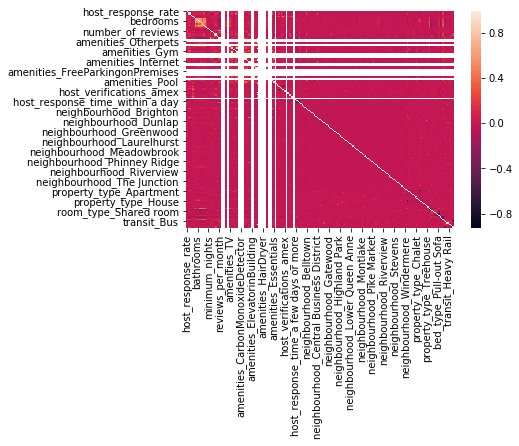

In [90]:
corr = df_lis10.corr()
sns.heatmap(corr)

In [15]:
df_rev = pd.read_csv(".\\Seattle\\reviews.csv")
df_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
